In [1]:
import pandas as pd 
from data_loading import load_tabular_data, preprocess_data
from NN import NN
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score
from GenDataset import GenDataset
from DVGS import DVGS
from DVGS2 import DVGS2
from DVRL import DVRL
import time
import DShap
import copy
import torchmetrics
import networkx as nx
from AEDataset import AEDataset
from AE import AE
import similarities
from matplotlib import pyplot as plt 
import statsmodels.api as sm
import scipy
from LINCSDataset import LINCSDataset
from LINCS_NN import LINCS_NN 

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# supervised with clean target

In [12]:
root = '../data/'

x_train = torch.load(f'{root}/lincs/l1000_data_VALID.pt')
x_valid = torch.load(f'{root}/lincs/l1000_data_TEST.pt')

train_ids = np.load('../data/lincs/l1000_ids_VALID.npy', allow_pickle=True)
test_ids = np.load('../data/lincs/l1000_ids_TEST.npy', allow_pickle=True)

instinfo = pd.read_csv('../data/instinfo_beta.txt', low_memory=False, sep='\t')
ids = np.concatenate((train_ids, test_ids),axis=0)
instinfo = instinfo[['sample_id', 'pert_id', 'cell_iname']]
instinfo = instinfo[lambda x: x.sample_id.isin(ids)]
pertspace = instinfo.pert_id.unique().astype(str)
cellspace = instinfo.cell_iname.unique().astype(str)

# zscore data 
x_mean = torch.mean(x_train, dim=0)
x_std = torch.std(x_train, dim=0)
x_train = (x_train - x_mean)/x_std
x_valid = (x_valid - x_mean)/x_std

noise_rates = []
for i in range(x_train.size(0)): 
    var = np.random.uniform(0,3,size=1)
    x_train[i, :] += torch.randn_like(x_train[i, :])*var
    noise_rates.append(var)

train_dataset = LINCSDataset(y=x_train, sample_ids=train_ids, pertspace=pertspace, cellspace=cellspace, data_dir='../data/')
valid_dataset = LINCSDataset(y=x_valid, sample_ids=test_ids, pertspace=pertspace, cellspace=cellspace, data_dir='../data/')

In [18]:
print('initializing models...')
model = LINCS_NN(cell_channels=64, cellspace=cellspace, pert_channels=64, pertspace=pertspace, out_channels=978, num_layers=2, hidden_channels=500, norm=False, dropout=0., bias=True, act=torch.nn.Mish)
dvgs = DVGS(train_dataset, valid_dataset, test_dataset=None, model=model)
dvgs.pretrain_(crit=torch.nn.MSELoss(), num_workers=1, batch_size=256, lr=1e-3, epochs=10, use_cuda=True, verbose=True, report_metric=None)
print('# of model params:', sum(p.numel() for p in model.parameters()))

tic = time.time() 
print('running dvgs...')
run_id = dvgs.run(crit                  = torch.nn.MSELoss(), 
                    save_dir              = '../temp_lincs2/',
                    similarity            = similarities.cosine_similarity(), 
                    optim                 = torch.optim.Adam,  
                    lr                    = 1e-3, 
                    num_epochs            = 10, 
                    compute_every         = 1, 
                    target_batch_size     = 2000, 
                    source_batch_size     = 512, 
                    num_workers           = 1, 
                    grad_params           = None, 
                    verbose               = True, 
                    use_cuda              = True)

initializing models...
using device: cuda
# of model params: 868442 metric: -666.0000
running dvgs...
using device: cuda


In [14]:
vals = dvgs.agg(f'../temp_lincs2/{run_id}/', reduction='mean')
vals.shape

(15966,)

In [15]:
lowess = sm.nonparametric.lowess
lowess_fit = lowess(vals.ravel(), np.array(noise_rates).ravel(), return_sorted=False, frac=0.1)

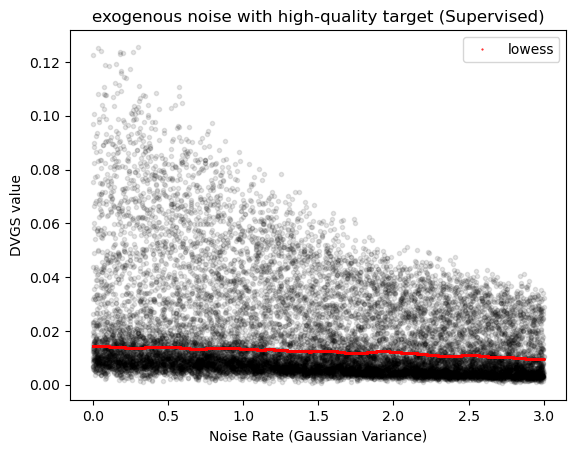

In [16]:
plt.figure()
plt.plot(noise_rates, vals, 'k.', alpha=0.1)
plt.plot(noise_rates, lowess_fit, 'r.', markersize=1, label='lowess')
plt.legend()
plt.xlabel('Noise Rate (Gaussian Variance)')
plt.ylabel('DVGS value')
plt.title('exogenous noise with high-quality target (Supervised)')
plt.show()

In [17]:
scipy.stats.spearmanr(noise_rates, vals)[0]

-0.30063210813964064

# Supervised with noisy target (ensemble)

In [2]:
root = '../data/'

x_train = torch.load(f'{root}/lincs/l1000_data_VALID.pt')
x_valid = torch.load(f'{root}/lincs/l1000_data_TEST.pt')

train_ids = np.load('../data/lincs/l1000_ids_VALID.npy', allow_pickle=True)
test_ids = np.load('../data/lincs/l1000_ids_TEST.npy', allow_pickle=True)

instinfo = pd.read_csv('../data/instinfo_beta.txt', low_memory=False, sep='\t')
ids = np.concatenate((train_ids, test_ids),axis=0)
instinfo = instinfo[['sample_id', 'pert_id', 'cell_iname']]
instinfo = instinfo[lambda x: x.sample_id.isin(ids)]
pertspace = instinfo.pert_id.unique().astype(str)
cellspace = instinfo.cell_iname.unique().astype(str)

# zscore data 
x_mean = torch.mean(x_train, dim=0)
x_std = torch.std(x_train, dim=0)
x_train = (x_train - x_mean)/x_std
x_valid = (x_valid - x_mean)/x_std

noise_rates = []
for i in range(x_train.size(0)): 
    var = np.random.uniform(0,3,size=1)
    x_train[i, :] += torch.randn_like(x_train[i, :])*var
    noise_rates.append(var)

In [3]:
res = np.zeros((x_train.size(0), 10), dtype=float)

for i in range(10): 
    print('step:', i)

    valid_idx = torch.tensor(np.random.randint(0,x_train.size(0), size=5000), dtype=torch.long)
    train_idx = torch.tensor(np.delete(np.arange(x_train.size(0)), valid_idx), dtype=torch.long)

    train_dataset = LINCSDataset(y=x_train[train_idx], sample_ids=train_ids, pertspace=pertspace, cellspace=cellspace, data_dir='../data/')
    valid_dataset = LINCSDataset(x_train[valid_idx], sample_ids=test_ids, pertspace=pertspace, cellspace=cellspace, data_dir='../data/')

    model = LINCS_NN(cell_channels=64, cellspace=cellspace, pert_channels=64, pertspace=pertspace, out_channels=978, num_layers=2, hidden_channels=500, norm=False, dropout=0., bias=True, act=torch.nn.Mish)
    dvgs = DVGS(train_dataset, valid_dataset, test_dataset=None, model=model)

    run_id = dvgs.run(crit                  = torch.nn.MSELoss(), 
                        save_dir              = '../temp_lincs/',
                        similarity            = similarities.cosine_similarity(), 
                        optim                 = torch.optim.Adam, 
                        lr                    = 1e-3, 
                        num_epochs            = 10, 
                        compute_every         = 1, 
                        target_batch_size     = 2500, 
                        source_batch_size     = 512, 
                        num_workers           = 1, 
                        grad_params           = None, 
                        verbose               = True, 
                        use_cuda              = True)

    vals = dvgs.agg(f'../temp_lincs/{run_id}')

    res[train_idx, i] = vals.ravel()

step: 0
using device: cuda
step: 1 || avg loss: 3.91 || grad time elapsed: 1.2 s] (0.0142 min/source-epoch)
using device: cuda
step: 2 || avg loss: 3.99 || grad time elapsed: 1.2 s] (0.0142 min/source-epoch)
using device: cuda
step: 3 || avg loss: 3.92 || grad time elapsed: 1.2 s] (0.0128 min/source-epoch)
using device: cuda
step: 4 || avg loss: 3.98 || grad time elapsed: 1.2 s] (0.0151 min/source-epoch)
using device: cuda
step: 5 || avg loss: 3.93 || grad time elapsed: 1.2 s] (0.0124 min/source-epoch)
using device: cuda
step: 6 || avg loss: 3.94 || grad time elapsed: 1.2 s] (0.0161 min/source-epoch)
using device: cuda
step: 7 || avg loss: 3.94 || grad time elapsed: 1.2 s] (0.0129 min/source-epoch)
using device: cuda
step: 8 || avg loss: 3.93 || grad time elapsed: 1.2 s] (0.0138 min/source-epoch)
using device: cuda
step: 9 || avg loss: 3.99 || grad time elapsed: 1.2 s] (0.0134 min/source-epoch)
using device: cuda


In [4]:
vals = res.mean(axis=1)
vals.shape

(15966,)

In [5]:
lowess = sm.nonparametric.lowess
lowess_fit = lowess(vals.ravel(), np.array(noise_rates).ravel(), return_sorted=False, frac=0.1)

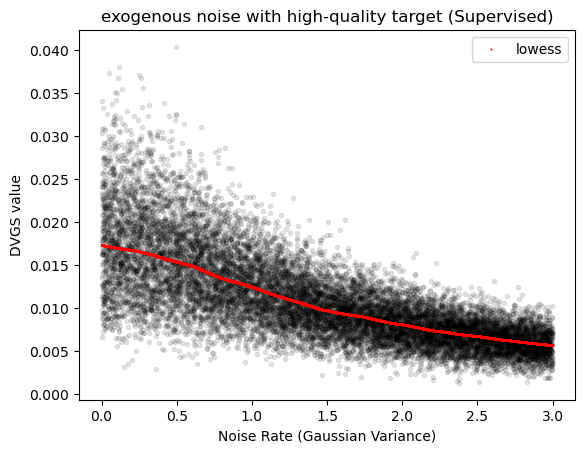

In [6]:
plt.figure()
plt.plot(noise_rates, vals, 'k.', alpha=0.1)
plt.plot(noise_rates, lowess_fit, 'r.', markersize=1, label='lowess')
plt.legend()
plt.xlabel('Noise Rate (Gaussian Variance)')
plt.ylabel('DVGS value')
plt.title('exogenous noise with high-quality target (Supervised)')
plt.show()

In [7]:
scipy.stats.spearmanr(noise_rates, vals)[0]

-0.7760223962148434

# Unsupervised with clean target 

In [84]:
root = '../data/'

x_train = torch.load(f'{root}/lincs/l1000_data_VALID.pt')
x_valid = torch.load(f'{root}/lincs/l1000_data_TEST.pt')

# zscore data 
x_mean = torch.mean(x_train, dim=0)
x_std = torch.std(x_train, dim=0)
x_train = (x_train - x_mean)/x_std
x_valid = (x_valid - x_mean)/x_std

noise_rates = []
for i in range(x_train.size(0)): 
    var = np.random.uniform(0,3,size=1)
    x_train[i, :] += torch.randn_like(x_train[i, :])*var
    noise_rates.append(var)

train_dataset = AEDataset(x_train)
valid_dataset = AEDataset(x_valid)

In [86]:

print('initializing models...')
model = AE(in_channels=978, latent_channels=64, hidden_channels=500, norm=False, dropout=0., bias=True, act=torch.nn.Mish, num_layers=1)
dvgs = DVGS(train_dataset, valid_dataset, test_dataset=None, model=model)
print('# of model params:', sum(p.numel() for p in model.parameters()))

tic = time.time() 
print('running dvgs...')
run_id = dvgs.run(crit                  = torch.nn.MSELoss(), 
                    save_dir              = '../temp_lincs/',
                    similarity            = similarities.cosine_similarity(), 
                    optim                 = torch.optim.Adam, 
                    lr                    = 1e-3, 
                    num_epochs            = 10, 
                    compute_every         = 1, 
                    target_batch_size     = 2000, 
                    source_batch_size     = 512, 
                    num_workers           = 1, 
                    grad_params           = None, 
                    verbose               = True, 
                    use_cuda              = True)

initializing models...
# of model params: 1044042
running dvgs...
using device: cuda


In [87]:
vals = dvgs.agg(f'../temp_lincs/{run_id}/', reduction='mean')
vals.shape

(15966,)

In [88]:
len(noise_rates)

15966

In [89]:

lowess = sm.nonparametric.lowess
lowess_fit = lowess(vals.ravel(), np.array(noise_rates).ravel(), return_sorted=False, frac=0.1)

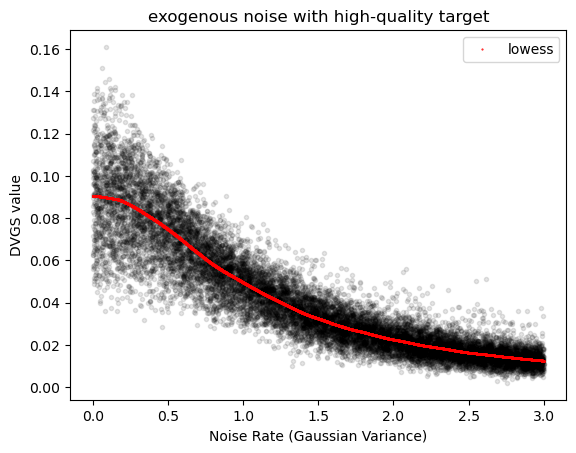

In [90]:
plt.figure()
plt.plot(noise_rates, vals, 'k.', alpha=0.1)
plt.plot(noise_rates, lowess_fit, 'r.', markersize=1, label='lowess')
plt.legend()
plt.xlabel('Noise Rate (Gaussian Variance)')
plt.ylabel('DVGS value')
plt.title('exogenous noise with high-quality target')
plt.show()

In [92]:
scipy.stats.spearmanr(noise_rates, vals)[0]

-0.9323398417414114

# Unsupervised with Noisy Target (ensemble)

In [2]:
root = '../data/'

x_train = torch.load(f'{root}/lincs/l1000_data_VALID.pt')

# zscore data 
x_mean = torch.mean(x_train, dim=0)
x_std = torch.std(x_train, dim=0)
x_train = (x_train - x_mean)/x_std

noise_rates = []
for i in range(x_train.size(0)): 
    var = np.random.uniform(0,3,size=1)
    x_train[i, :] += torch.randn_like(x_train[i, :])*var
    noise_rates.append(var)


In [3]:
res = np.zeros((x_train.size(0), 10), dtype=float)

for i in range(10): 
    print('step:', i)

    valid_idx = torch.tensor(np.random.randint(0,x_train.size(0), size=5000), dtype=torch.long)
    train_idx = torch.tensor(np.delete(np.arange(x_train.size(0)), valid_idx), dtype=torch.long)

    train_dataset = AEDataset(x_train[train_idx])
    valid_dataset = AEDataset(x_train[valid_idx])

    model = AE(in_channels=978, latent_channels=64, hidden_channels=500, norm=False, dropout=0., bias=True, act=torch.nn.Mish, num_layers=1)
    dvgs = DVGS(train_dataset, valid_dataset, test_dataset=None, model=model)

    run_id = dvgs.run(crit                  = torch.nn.MSELoss(), 
                        save_dir              = '../temp_lincs/',
                        similarity            = similarities.cosine_similarity(), 
                        optim                 = torch.optim.Adam, 
                        lr                    = 1e-3, 
                        num_epochs            = 10, 
                        compute_every         = 1, 
                        target_batch_size     = 2500, 
                        source_batch_size     = 512, 
                        num_workers           = 1, 
                        grad_params           = None, 
                        verbose               = True, 
                        use_cuda              = True)

    vals = dvgs.agg(f'../temp_lincs/{run_id}')

    res[train_idx, i] = vals.ravel()
    


step: 0
using device: cuda
step: 1 || avg loss: 3.48 || grad time elapsed: 1.4 s] (0.0155 min/source-epoch)
using device: cuda
step: 2 || avg loss: 3.51 || grad time elapsed: 1.3 s] (0.0170 min/source-epoch)
using device: cuda
step: 3 || avg loss: 3.41 || grad time elapsed: 1.3 s] (0.0145 min/source-epoch)
using device: cuda
step: 4 || avg loss: 3.43 || grad time elapsed: 1.3 s] (0.0157 min/source-epoch)
using device: cuda
step: 5 || avg loss: 3.45 || grad time elapsed: 1.3 s] (0.0161 min/source-epoch)
using device: cuda
step: 6 || avg loss: 3.43 || grad time elapsed: 1.3 s] (0.0168 min/source-epoch)
using device: cuda
step: 7 || avg loss: 3.45 || grad time elapsed: 1.3 s] (0.0157 min/source-epoch)
using device: cuda
step: 8 || avg loss: 3.43 || grad time elapsed: 1.3 s] (0.0157 min/source-epoch)
using device: cuda
step: 9 || avg loss: 3.45 || grad time elapsed: 1.3 s] (0.0172 min/source-epoch)
using device: cuda


In [5]:
vals = res.mean(axis=1)
vals.shape

(15966,)

In [10]:
scipy.stats.spearmanr(noise_rates, vals)[0]

-0.8687607394076932

In [7]:
lowess = sm.nonparametric.lowess
lowess_fit = lowess(vals.ravel(), np.array(noise_rates).ravel(), return_sorted=False, frac=0.1)

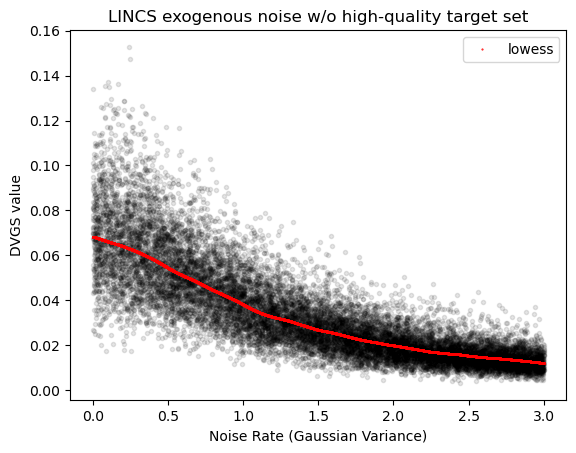

In [8]:
plt.figure()
plt.plot(noise_rates, vals, 'k.', alpha=0.1)
plt.plot(noise_rates, lowess_fit, 'r.', markersize=1, label='lowess')
plt.legend()
plt.xlabel('Noise Rate (Gaussian Variance)')
plt.ylabel('DVGS value')
plt.title('LINCS exogenous noise w/o high-quality target set')
plt.show()

In [57]:
buffer = scipy.io.mmread('../data/sub_set-720.mtx')

In [58]:
buffer.toarray().shape

(3005, 720)

In [62]:
labels = [int(x.strip()[0]) for x in open('../data/labels.txt', 'r').readlines()]
labels[0:5]

[1, 1, 1, 1, 1]